In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Định nghĩa dataloader

In [2]:
# Ô này tạm thời bỏ qua không quan tâm nhiều
class CMAPSSDataset(Dataset):
    def __init__(self, data, seq_len=30):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_len, :-1]
        target = self.data[idx + self.seq_len - 1, -1]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [3]:
# Trong pytorch, dữ liệu phải được đưa vào một đối tượng mà pytorch có thể tự động đọc, điều này không giống trong keras do cách
# hoạt động khác nhau của mỗi framework
# FD003Dataset sẽ là nơi làm việc này, và trong này cũng miêu tả cách dữ liệu được xử lý như thế nào luôn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class FD003Dataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data # Truyền vào data frame đã được xử lý ở trên
        self.sequence_length = sequence_length # Chỉ định khung cho mỗi mẫu data, ta lấy 30 dòng để dự đoán cho dòng 30
        self.sequences = [] # Cứ mỗi lần lấy ra 30 dòng thì thêm nó vào đây
        self.targets = [] # Nhãn càn dự đoán là RUL của dòng cuối cùng được lấy ra
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


## Định nghĩa mô hình Transformer

In [4]:
# Xây dựng kiến trúc mô hình Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)


## Loading dataset and preprocessing

In [5]:
train_3 = "../data/train_FD003.txt"

In [6]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_3 = pd.read_csv(train_3, sep=' ', header=None)
train_3.drop([26, 27], axis=1, inplace=True)
train_3.columns = column_names

train_3['Remaining RUL'] = ''
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,


In [7]:
# remaining_rul = max_rul - cycle
max_cycle = train_3.groupby('ID Engine').count()
for idx in range(len(train_3)):
    train_3.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_3.loc[idx, 'ID Engine'], 'Cycle']
train_3['Remaining RUL'] = train_3['Remaining RUL'] - train_3['Cycle']

In [8]:
train_3 = train_3.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_3.head()

,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,642.36,1583.23,1396.84,553.97,2387.96,9062.17,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,258
1,1,2,642.50,1584.69,1396.89,554.55,2388.00,9061.78,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,257
2,1,3,642.18,1582.35,1405.61,554.43,2388.03,9070.23,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,256
3,1,4,642.92,1585.61,1392.27,555.21,2388.00,9064.57,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,255
4,1,5,641.68,1588.63,1397.65,554.74,2388.04,9076.14,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,254


In [9]:
# Chuẩn hóa dữ liệu
df = train_3.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.355972,0.370523,0.308580,0.208812,0.623529,0.204233,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331,0.492366
1,1,2,0.388759,0.399100,0.309360,0.236590,0.647059,0.202431,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836,0.490458
2,1,3,0.313817,0.353298,0.445398,0.230843,0.664706,0.241484,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577,0.488550
3,1,4,0.487119,0.417107,0.237285,0.268199,0.647059,0.215326,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966,0.486641
4,1,5,0.196721,0.476218,0.321217,0.245690,0.670588,0.268799,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371,0.484733


## Huấn luyện mô hình với sequence_length = 50, 50 epochs

In [10]:
# Đưa dataset vào dataloader
dataset = FD003Dataset(df, sequence_length=50)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [11]:
dataset.__len__()

19820

In [12]:
train_data.__len__()

15856

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD003Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 14
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.02158595738658351, Val Loss = 0.011036081930562373
Epoch 2: Train Loss = 0.013612750270817008, Val Loss = 0.010626114548123893
Epoch 3: Train Loss = 0.012292679027943391, Val Loss = 0.0106535988292777
Epoch 4: Train Loss = 0.011556993865768516, Val Loss = 0.009331019495749064
Epoch 5: Train Loss = 0.009963202931460054, Val Loss = 0.00928015734684924
Epoch 6: Train Loss = 0.008644864175772865, Val Loss = 0.006949890908154268
Epoch 7: Train Loss = 0.007544895835200159, Val Loss = 0.00645841671446819
Epoch 8: Train Loss = 0.00704063332006861, Val Loss = 0.006181120181516293
Epoch 9: Train Loss = 0.006776564675918405, Val Loss = 0.006239687993882164
Epoch 10: Train Loss = 0.006493235096821727, Val Loss = 0.006136744758189325
Epoch 11: Train Loss = 0.00623695207703408, Val Loss = 0.005924340556263023
Epoch 12: Train Loss = 0.006231697527607227, Val Loss = 0.006445331636989009
Epoch 13: Train Loss = 0.005948553990287286, Val Loss = 0.005764391960486049
Epoch 14: Train

In [14]:
model.eval()
sample, _ = dataset[0]
sample = sample.unsqueeze(0).to(device)  
predicted_rul = model(sample)
print(f"Predicted RUL: {predicted_rul.item()}")

Predicted RUL: 0.3285239338874817


In [15]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [16]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


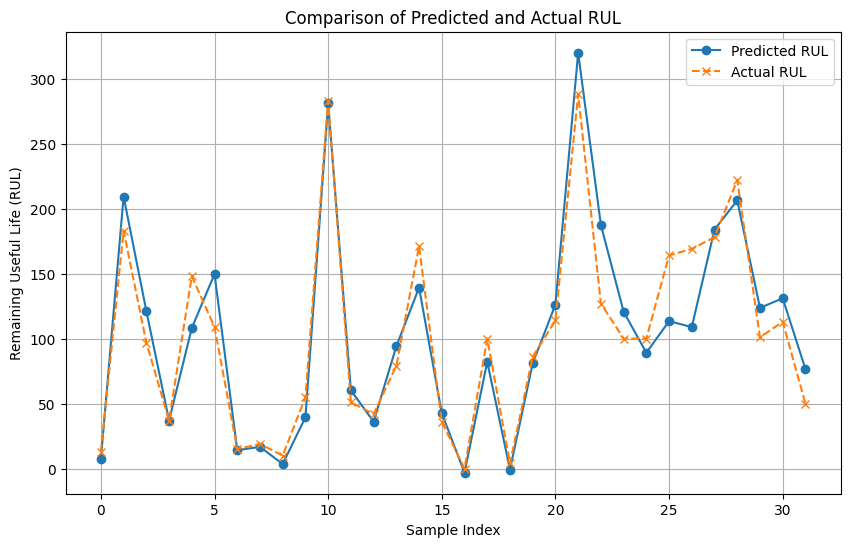

In [17]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 10, 50 epochs

In [18]:
# Đưa dataset vào dataloader
dataset = FD003Dataset(df, sequence_length=10)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD003Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 14
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.02545297869415516, Val Loss = 0.012276664274688435
Epoch 2: Train Loss = 0.015528390793467328, Val Loss = 0.012211624850150224
Epoch 3: Train Loss = 0.014307030203170925, Val Loss = 0.012027867908758306
Epoch 4: Train Loss = 0.013564039211588969, Val Loss = 0.011914307285950288
Epoch 5: Train Loss = 0.013316364063890713, Val Loss = 0.011485298940811881
Epoch 6: Train Loss = 0.012987208281153026, Val Loss = 0.011418597058599328
Epoch 7: Train Loss = 0.012812213927285508, Val Loss = 0.011306973386730923
Epoch 8: Train Loss = 0.01261030814857316, Val Loss = 0.011584525856020666
Epoch 9: Train Loss = 0.012381882195426588, Val Loss = 0.011555779061198935
Epoch 10: Train Loss = 0.012435102377840061, Val Loss = 0.011158263090460393
Epoch 11: Train Loss = 0.012246074199898406, Val Loss = 0.012192076773713999
Epoch 12: Train Loss = 0.0122085243784635, Val Loss = 0.011077580589101018
Epoch 13: Train Loss = 0.012107666645155307, Val Loss = 0.011161568673052544
Epoch 14: Tr

In [20]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [21]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


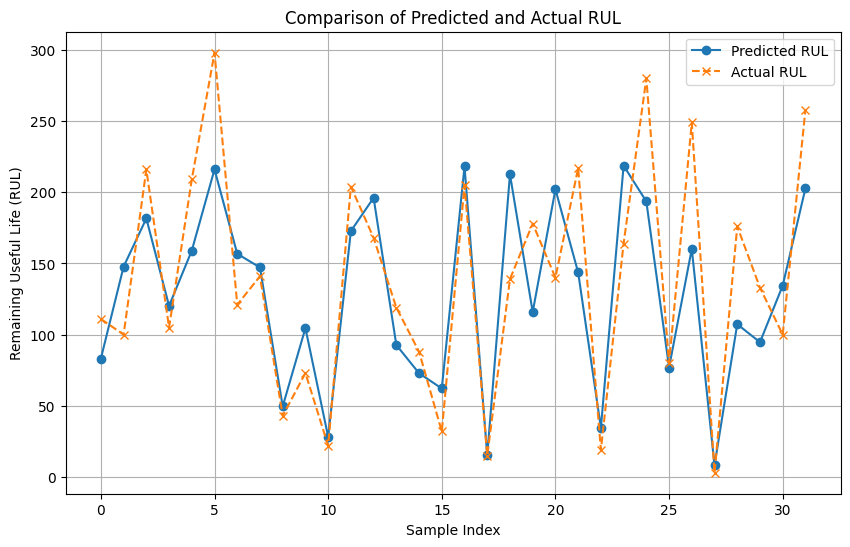

In [22]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 30, 50 epochs

In [23]:
# Đưa dataset vào dataloader
dataset = FD003Dataset(df, sequence_length=30)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD003Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 14
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.02403471509980604, Val Loss = 0.011726091129800482
Epoch 2: Train Loss = 0.015319188826482047, Val Loss = 0.011610459923798586
Epoch 3: Train Loss = 0.01377592746495873, Val Loss = 0.011243487624995356
Epoch 4: Train Loss = 0.012504093375845024, Val Loss = 0.010454994548166539
Epoch 5: Train Loss = 0.011200919121780157, Val Loss = 0.010282878701092445
Epoch 6: Train Loss = 0.010180088259013636, Val Loss = 0.009369904584978727
Epoch 7: Train Loss = 0.009728158329060854, Val Loss = 0.00902109262771415
Epoch 8: Train Loss = 0.0092012973021692, Val Loss = 0.00828593013889707
Epoch 9: Train Loss = 0.00895427049251935, Val Loss = 0.008316795361214692
Epoch 10: Train Loss = 0.008618918655614195, Val Loss = 0.008361694251737781
Epoch 11: Train Loss = 0.008471775538588263, Val Loss = 0.007907318399138205
Epoch 12: Train Loss = 0.008365467254706955, Val Loss = 0.008145126752915663
Epoch 13: Train Loss = 0.008214928437495134, Val Loss = 0.007767278791140139
Epoch 14: Train

In [25]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [26]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


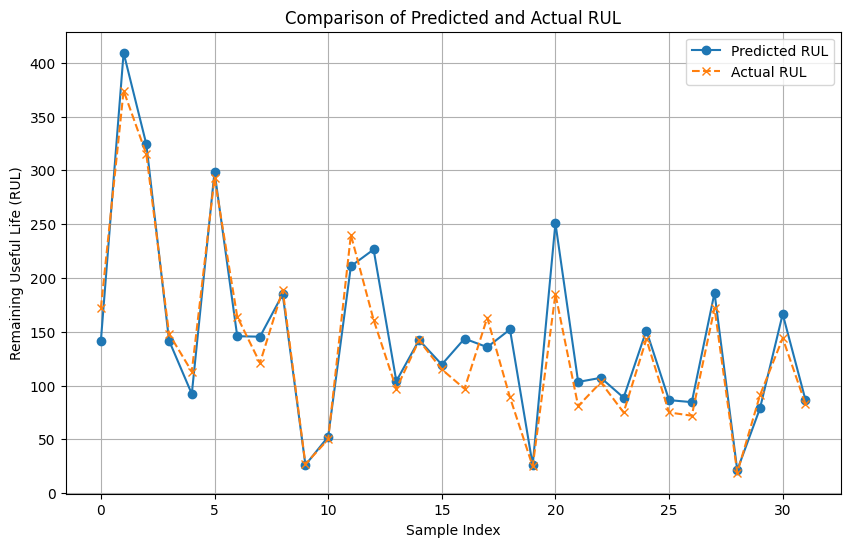

In [27]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


##

In [28]:
# import shap 
# shap.__version__

In [29]:
# samples, targets = next(iter(val_loader))
# print(samples[1].__len__())

In [30]:
# # Define a wrapper to explain the Transformer model
# class TransformerWrapper:
#     def __init__(self, model):
#         self.model = model

#     def __call__(self, inputs):
#         # Convert inputs to tensor if not already
#         if not isinstance(inputs, torch.Tensor):
#             inputs = torch.tensor(inputs, dtype=torch.float32)
#         inputs = inputs.to(device)  # Send to the same device as the model
#         with torch.no_grad():
#             outputs = self.model(inputs)
#         return outputs.cpu().numpy()

In [31]:
# # Instantiate the wrapper
# explainer_model = TransformerWrapper(model)

# sample_data = samples[0]
# sample_data = sample_data.numpy()

# # Ensure sample_data and baseline have correct dimensions
# baseline = np.mean(sample_data, axis=0, keepdims=True)  # Mean across batch
# baseline = baseline[np.newaxis, :, :]  # Add batch dimension to ensure 3D shape: [1, seq_len, feature_dim]
# print(f'baseline shape = {baseline.shape}')

# # SHAP explainer (Kernel SHAP for simplicity)
# explainer = shap.KernelExplainer(explainer_model, baseline)

# # Generate SHAP values
# shap_values = explainer.shap_values(sample_data)
# print(f'shap values = {shap_values.shape}')

In [32]:
# print(f'shap values = {shap_values.shape}')
# shap.summary_plot(shap_values, sample_data)